In [1]:
#Project: Wine reviews classification project
#Data source: 150k reviews from Wine Euthusiast Magazine in 2017 found on Kaggle
#Data source link: https://www.kaggle.com/datasets/zynicide/wine-reviews
#Group members: Meichan Huang, Nicholas Nguyen, and Erika Gosselin-Preston
#Date: Dec 19 2022

Rationale: We chose this wine review data in the hope to see if the description of a wine or review of a wine can predict how many points it can receive. 
Data source: We have chosen a 150k entries data scrapped from Wine Enthusiast in 2017. The data is available on Kaggle
https://www.kaggle.com/datasets/zynicide/wine-reviews). 

For this project, our team has done the following analysis: 

Data preprocessing (Meichan):
- handle the null values
- tokenize the words
- pos tagging the sentences and extract nouns, adjs, noun phrases, adj phrases

Data visualization:
- Top 20 unigram frequencies (tokens, noun, adjectives and their wordclouds; and bigram frequencies (Meichan)
- Word clouds with bag of words, noun phrases, and adjective phrases (Eryka)
- Histograms with price and points (Meichan)

More data preprocessing: (Nicholas)
- Make categorical variable of Quality with points 
- Make categorical variable price_val with price
- Data analysis with groupby 

Classification tasks:
- Naive Bayes models: (Nicholas initiated this model)
   - price and points (Nicholas)
   - tokenized words, adjectives, nouns v.s. quality (wine points categories) respectively (3 models by Meichan): among which tokenized word has the best model accuracy of 67% to predict wine quality. 
   - tokenized words, adjectives, nouns v.s. price_val (price categories) respectively (3 models by Meichan): again, tokenized words has the best accuracy of 48% to predict the price. 
   - tokenized words, adjectives, nouns v.s. varieties (we picked top 4 wine varieties only as there were over 500 types) respectively (3 models by Meichan) again, tokenized words has the best accuracy of 88% to predict varieties. 

We also tried svm but it took very long to run it and was not successful

References:  
Kiren, J. (2022). Text mining and sentiment analysis with NLTK and pandas in Python. 
Retrieved from: https://www.kirenz.com/post/2021-12-11-text-mining-and-sentiment-analysis-with-nltk-and-pandas-in-python/text-mining-and-sentiment-analysis-with-nltk-and-pandas-in-python/

In [405]:
'''Meichan: Import necessary packages for import the dataframe'''
import nltk
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [406]:
'''Meichan: Step 1: Import the textual data from the pandas dataframe and preprocess for analysis'''

#Read the data from the csv file with necessary columns for the analysis: 
column_names = ["Index", "Country", "Review", "Designation", "Points", "Price", 
             "Province", "Region_1", "Region_2", "Variety", "Winery"]
winereviews = pd.read_csv('winemag-data_first150k.csv',sep=",", header=1, 
                        names = column_names, index_col=0)



#Inspect the first five rows of the data and see if they are read correct
winereviews.head()

,Country,Review,Designation,Points,Price,Province,Region_1,Region_2,Variety,Winery
Index,,,,,,,,,,
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude
5,Spain,"Deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Toro,NaN,Tinta de Toro,Numanthia


In [407]:
#Meichan: Inspect the shape of the data, how many rows and columns specifically. 
shape = winereviews.shape
print("The shape of the dataframe (rows, columns):\t {}".format(shape))
#Inspect the data types for the dataframe
winereviews.dtypes
winereviews.describe()

The shape of the dataframe (rows, columns):	 (150929, 10)


,Points,Price
count,150929.000000,137234.000000
mean,87.888365,33.130012
std,3.222335,36.318581
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,24.000000
75%,90.000000,40.000000
max,100.000000,2300.000000


In [408]:
#Meichan: Inspect empty values and impute the data if needed.
print(winereviews.isnull().any())   #Is there any NAs in each column and the output is a boolean value. 
print(winereviews.isnull().sum())  #the total number of null values in each column

Country         True
Review         False
Designation     True
Points         False
Price           True
Province        True
Region_1        True
Region_2        True
Variety        False
Winery         False
dtype: bool
Country            5
Review             0
Designation    45735
Points             0
Price          13695
Province           5
Region_1       25060
Region_2       89977
Variety            0
Winery             0
dtype: int64


'The most important variables that will need to be used are: country, reviews, price, points, and variety. \n#Therefore, the treatment of NAs in the dataset will focus on the following columns and treatment specified: \n(1) Country: remove the ones without a country (5 records)\n(2) Price: impute the price (13695 records)\n'

Data preprocessing considerations: The most important variables that will need to be used are: country, reviews, price, points, and variety. 
#Therefore, the treatment of NAs in the dataset will focus on the following columns and treatment specified: 
(1) Country: remove the ones without a country (5 records)
(2) Price: impute the price (13695 records)

In [409]:
#Meichan: Remove the records with NAs in the country column:
winereviews = winereviews.dropna(how="any", subset=["Country"])

/Users/meichanhuang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


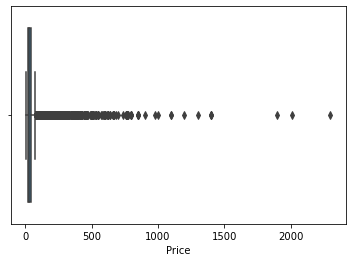

In [410]:
#Meichan: Impute the price: https://vitalflux.com/pandas-impute-missing-values-mean-median-mode/
#Visualize the price column and see the distribution of the data
import seaborn as sns  
sns.boxplot(winereviews.Price)
#It looks like the data is rather skewed, therefore, taking the mode (the most frequent price) would be a good strategy. 

winereviews['Price'] = winereviews['Price'].fillna(winereviews['Price'].mode()[0])

In [411]:
#Meichan: Check the updated dataframe with the columns with necessary NA processing 
winereviews.describe()

,Points,Price
count,150924.000000,150924.000000
mean,87.888474,31.939069
std,3.222233,34.836879
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,22.000000
75%,90.000000,38.000000
max,100.000000,2300.000000


In [412]:
'''Meichan: Step 2: Process the review text and tokenize the data '''

#Meichan: Create a new dataframe so that we don't have to mess up the original dataframe
reviewdf = winereviews      

##start with all lower cases     
reviewdf['Review'] = reviewdf['Review'].astype(str).str.lower()     

In [413]:
#Tokenize the sentence and attach POS to each tokens. https://stackoverflow.com/questions/41674573/how-to-apply-pos-tag-sents-to-pandas-dataframe-efficiently
reviewdf['TaggedReview'] = nltk.pos_tag_sents(reviewdf['Review'].apply(nltk.word_tokenize).tolist() )

In [414]:
#Extract the nouns in each row only:
reviewdf['nouns'] = reviewdf['TaggedReview'].apply(lambda x: [word for word, tag in x if tag in ['NN', 'NNS', 'NNP', 'NNPS']])

In [415]:
#Preview the dataframe
reviewdf.head()

,Country,Review,Designation,Points,Price,Province,Region_1,Region_2,Variety,Winery,TaggedReview,nouns
Index,,,,,,,,,,,,
1,Spain,"ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,"[(ripe, JJ), (aromas, NN), (of, IN), (fig, NN)...","[aromas, fig, blackberry, cassis, slathering, ..."
2,US,mac watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,"[(mac, NN), (watson, NN), (honors, VBZ), (the,...","[mac, watson, memory, wine, mother, gold, colo..."
3,US,"this spent 20 months in 30% new french oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,"[(this, DT), (spent, VBD), (20, CD), (months, ...","[months, %, oak, fruit, ponzi, aurora, abetina..."
4,France,"this is the top wine from la bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,"[(this, DT), (is, VBZ), (the, DT), (top, JJ), ...","[wine, bégude, point, vineyard, feet, structur..."
5,Spain,"deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Toro,NaN,Tinta de Toro,Numanthia,"[(deep, RB), (,, ,), (dense, NN), (and, CC), (...","[dense, pure, opening, bell, toro, winner, aro..."


In [416]:
#Extract the adjs in each row only:
reviewdf['adjectives'] = reviewdf['TaggedReview'].apply(lambda x: [word for word, tag in x if tag in ['JJ', 'JJR', 'JJS']])

In [417]:
reviewdf.head()

,Country,Review,Designation,Points,Price,Province,Region_1,Region_2,Variety,Winery,TaggedReview,nouns,adjectives
Index,,,,,,,,,,,,,
1,Spain,"ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,"[(ripe, JJ), (aromas, NN), (of, IN), (fig, NN)...","[aromas, fig, blackberry, cassis, slathering, ...","[ripe, oaky, full, intense, rich, black, heady]"
2,US,mac watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,"[(mac, NN), (watson, NN), (honors, VBZ), (the,...","[mac, watson, memory, wine, mother, gold, colo...","[delicious, balanced, complex, white, dark, pe..."
3,US,"this spent 20 months in 30% new french oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,"[(this, DT), (spent, VBD), (20, CD), (months, ...","[months, %, oak, fruit, ponzi, aurora, abetina...","[new, french, aromatic, dense, toasty, aromas,..."
4,France,"this is the top wine from la bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,"[(this, DT), (is, VBZ), (the, DT), (top, JJ), ...","[wine, bégude, point, vineyard, feet, structur...","[top, la, highest, considerable, extra, tari]"
5,Spain,"deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Toro,NaN,Tinta de Toro,Numanthia,"[(deep, RB), (,, ,), (dense, NN), (and, CC), (...","[dense, pure, opening, bell, toro, winner, aro...","[dark, ripe, black, cool, feels, toasty, heady..."


Meichan: Create a separate column with words tokenized, punctuation, stopwords removed for the word cloud.

To make the process faster, I found this solution: https://stackoverflow.com/questions/33098040/how-to-use-word-tokenize-in-data-frame
reviewdf['tokenized_word'] = reviewdf['Review'].apply(lambda x: nltk.word_tokenize(x))

In [419]:
reviewdf['tokenized_words'] = reviewdf['Review'].apply(nltk.word_tokenize).tolist() 

In [420]:
reviewdf.head()

,Country,Review,Designation,Points,Price,Province,Region_1,Region_2,Variety,Winery,TaggedReview,nouns,adjectives,tokenized_words
Index,,,,,,,,,,,,,,
1,Spain,"ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,"[(ripe, JJ), (aromas, NN), (of, IN), (fig, NN)...","[aromas, fig, blackberry, cassis, slathering, ...","[ripe, oaky, full, intense, rich, black, heady]","[ripe, aromas, of, fig, ,, blackberry, and, ca..."
2,US,mac watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,"[(mac, NN), (watson, NN), (honors, VBZ), (the,...","[mac, watson, memory, wine, mother, gold, colo...","[delicious, balanced, complex, white, dark, pe...","[mac, watson, honors, the, memory, of, a, wine..."
3,US,"this spent 20 months in 30% new french oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,"[(this, DT), (spent, VBD), (20, CD), (months, ...","[months, %, oak, fruit, ponzi, aurora, abetina...","[new, french, aromatic, dense, toasty, aromas,...","[this, spent, 20, months, in, 30, %, new, fren..."
4,France,"this is the top wine from la bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,"[(this, DT), (is, VBZ), (the, DT), (top, JJ), ...","[wine, bégude, point, vineyard, feet, structur...","[top, la, highest, considerable, extra, tari]","[this, is, the, top, wine, from, la, bégude, ,..."
5,Spain,"deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Toro,NaN,Tinta de Toro,Numanthia,"[(deep, RB), (,, ,), (dense, NN), (and, CC), (...","[dense, pure, opening, bell, toro, winner, aro...","[dark, ripe, black, cool, feels, toasty, heady...","[deep, ,, dense, and, pure, from, the, opening..."


In [421]:
#Remove the punctuation and numbers 
import re
def alpha_filter(w):
     pattern = re.compile('^[^a-z]+$')
     if (pattern.match(w)):
         return True
     else:
         return False   
reviewdf['word_token_cleaned'] = reviewdf['tokenized_words'].apply(lambda x:[i for i in x if not alpha_filter(i)])

In [422]:
#Remove stopwords and punctuation 
from nltk.corpus import stopwords
# Make a list of english stopwords
stopwords = nltk.corpus.stopwords.words("english")
mystopwords = ['drink' , 'now', 'wine' ,'flavour','flavor', "'s", 'still', 'flavours', 'flavors', "'ll", '%']
stopwords.extend(mystopwords)

#Save a new column to store the preprocessed word tokens 
reviewdf['word_token_cleaned'] = reviewdf['word_token_cleaned'].apply(lambda x:[i for i in x if i not in stopwords])

In [423]:
#Inspect the dataframe that have been cleaned
reviewdf.head()

,Country,Review,Designation,Points,Price,Province,Region_1,Region_2,Variety,Winery,TaggedReview,nouns,adjectives,tokenized_words,word_token_cleaned
Index,,,,,,,,,,,,,,,
1,Spain,"ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,"[(ripe, JJ), (aromas, NN), (of, IN), (fig, NN)...","[aromas, fig, blackberry, cassis, slathering, ...","[ripe, oaky, full, intense, rich, black, heady]","[ripe, aromas, of, fig, ,, blackberry, and, ca...","[ripe, aromas, fig, blackberry, cassis, soften..."
2,US,mac watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,"[(mac, NN), (watson, NN), (honors, VBZ), (the,...","[mac, watson, memory, wine, mother, gold, colo...","[delicious, balanced, complex, white, dark, pe...","[mac, watson, honors, the, memory, of, a, wine...","[mac, watson, honors, memory, made, mother, tr..."
3,US,"this spent 20 months in 30% new french oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,"[(this, DT), (spent, VBD), (20, CD), (months, ...","[months, %, oak, fruit, ponzi, aurora, abetina...","[new, french, aromatic, dense, toasty, aromas,...","[this, spent, 20, months, in, 30, %, new, fren...","[spent, months, new, french, oak, incorporates..."
4,France,"this is the top wine from la bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,"[(this, DT), (is, VBZ), (the, DT), (top, JJ), ...","[wine, bégude, point, vineyard, feet, structur...","[top, la, highest, considerable, extra, tari]","[this, is, the, top, wine, from, la, bégude, ,...","[top, la, bégude, named, highest, point, viney..."
5,Spain,"deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Toro,NaN,Tinta de Toro,Numanthia,"[(deep, RB), (,, ,), (dense, NN), (and, CC), (...","[dense, pure, opening, bell, toro, winner, aro...","[dark, ripe, black, cool, feels, toasty, heady...","[deep, ,, dense, and, pure, from, the, opening...","[deep, dense, pure, opening, bell, toro, winne..."


In [424]:
#Start with a regex expression to find adjs, following the sample codes provided by the professor.
grammar_adjph = "ADJPH: {<RB.?>+<JJ.?>}"
# This regex reads as: "find groups ("< >") of RBs (adverbs) together with groups of JJs (adjectives), with groups defineds as
# RBs with any ending (the "." is a placeholder or wildcard for the "R" and the "S" at the end of RBR and RBS, 
# while "?" indicates "optional character" so RB can be found alone as well). Same regex operators apply to JJs.

# Second step: import the nltk parser to process each sentence
chunk_parser_adj = nltk.RegexpParser(grammar_adjph)

tagged_reviews = reviewdf['TaggedReview'].tolist()
for sent in tagged_reviews[:2]:
    print(sent)

[('ripe', 'JJ'), ('aromas', 'NN'), ('of', 'IN'), ('fig', 'NN'), (',', ','), ('blackberry', 'NN'), ('and', 'CC'), ('cassis', 'NN'), ('are', 'VBP'), ('softened', 'VBN'), ('and', 'CC'), ('sweetened', 'VBN'), ('by', 'IN'), ('a', 'DT'), ('slathering', 'NN'), ('of', 'IN'), ('oaky', 'JJ'), ('chocolate', 'NN'), ('and', 'CC'), ('vanilla', 'NN'), ('.', '.'), ('this', 'DT'), ('is', 'VBZ'), ('full', 'JJ'), (',', ','), ('layered', 'VBD'), (',', ','), ('intense', 'JJ'), ('and', 'CC'), ('cushioned', 'VBN'), ('on', 'IN'), ('the', 'DT'), ('palate', 'NN'), (',', ','), ('with', 'IN'), ('rich', 'JJ'), ('flavors', 'NNS'), ('of', 'IN'), ('chocolaty', 'NN'), ('black', 'JJ'), ('fruits', 'NNS'), ('and', 'CC'), ('baking', 'VBG'), ('spices', 'NNS'), ('.', '.'), ('a', 'DT'), ('toasty', 'NN'), (',', ','), ('everlasting', 'VBG'), ('finish', 'NN'), ('is', 'VBZ'), ('heady', 'JJ'), ('but', 'CC'), ('ideally', 'RB'), ('balanced', 'VBD'), ('.', '.'), ('drink', 'VB'), ('through', 'IN'), ('2023', 'CD'), ('.', '.')]
[('mac'

In [425]:
adjphrase = []

for sent in tagged_reviews:

    tree = chunk_parser_adj.parse(sent)

    adj_tree = []

    for subtree in tree.subtrees():

        if subtree.label() == 'ADJPH':

            adj_tree.append(subtree)

 

  # print(adj_tree)
    adjective_phrases = []

    for sent in adj_tree:

        temp = ''

        for w, t in sent:

            temp += w + " "

        adjective_phrases.append(temp)

  # print(adjective_phrases)
    adjphrase.append(adjective_phrases)

In [431]:
adjph = pd.Series(adjphrase)

reviewdf = reviewdf.assign(adjphrases = adjph)  

In [432]:
reviewdf.head()

,Country,Review,Designation,Points,Price,Province,Region_1,Region_2,Variety,Winery,TaggedReview,nouns,adjectives,tokenized_words,word_token_cleaned,adjphrases
Index,,,,,,,,,,,,,,,,
1,Spain,"ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,"[(ripe, JJ), (aromas, NN), (of, IN), (fig, NN)...","[aromas, fig, blackberry, cassis, slathering, ...","[ripe, oaky, full, intense, rich, black, heady]","[ripe, aromas, of, fig, ,, blackberry, and, ca...","[ripe, aromas, fig, blackberry, cassis, soften...",[tremendously delicious ]
2,US,mac watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,"[(mac, NN), (watson, NN), (honors, VBZ), (the,...","[mac, watson, memory, wine, mother, gold, colo...","[delicious, balanced, complex, white, dark, pe...","[mac, watson, honors, the, memory, of, a, wine...","[mac, watson, honors, memory, made, mother, tr...",[]
3,US,"this spent 20 months in 30% new french oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,"[(this, DT), (spent, VBD), (20, CD), (months, ...","[months, %, oak, fruit, ponzi, aurora, abetina...","[new, french, aromatic, dense, toasty, aromas,...","[this, spent, 20, months, in, 30, %, new, fren...","[spent, months, new, french, oak, incorporates...",[]
4,France,"this is the top wine from la bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,"[(this, DT), (is, VBZ), (the, DT), (top, JJ), ...","[wine, bégude, point, vineyard, feet, structur...","[top, la, highest, considerable, extra, tari]","[this, is, the, top, wine, from, la, bégude, ,...","[top, la, bégude, named, highest, point, viney...",[]
5,Spain,"deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Toro,NaN,Tinta de Toro,Numanthia,"[(deep, RB), (,, ,), (dense, NN), (and, CC), (...","[dense, pure, opening, bell, toro, winner, aro...","[dark, ripe, black, cool, feels, toasty, heady...","[deep, ,, dense, and, pure, from, the, opening...","[deep, dense, pure, opening, bell, toro, winne...","[slightly gritty , highly impressive ]"


In [433]:
#Start with a regex expression to find noun phrases, following the sample codes provided by the professor.
grammar_nounph = "NP:{<DT>?<JJ>*<NN>}"

# Second step: import the nltk parser to process each sentence
chunk_parser_noun = nltk.RegexpParser(grammar_nounph)


In [434]:
nounphrase = []

for sent in tagged_reviews:

    tree = chunk_parser_noun.parse(sent)

    noun_tree = []

    for subtree in tree.subtrees():

        if subtree.label() == 'NP':

            noun_tree.append(subtree)

 

  # print(noun_tree)
    noun_phrases = []

    for sent in noun_tree:

        temp = ''

        for w, t in sent:

            temp += w + " "

        noun_phrases.append(temp)

  # print(noun_phrases)
    nounphrase.append(noun_phrases)

nph = pd.Series(nounphrase)

reviewdf = reviewdf.assign(nounphrases = nph) 

In [435]:
reviewdf.head()

,Country,Review,Designation,Points,Price,Province,Region_1,Region_2,Variety,Winery,TaggedReview,nouns,adjectives,tokenized_words,word_token_cleaned,adjphrases,nounphrases
Index,,,,,,,,,,,,,,,,,
1,Spain,"ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,"[(ripe, JJ), (aromas, NN), (of, IN), (fig, NN)...","[aromas, fig, blackberry, cassis, slathering, ...","[ripe, oaky, full, intense, rich, black, heady]","[ripe, aromas, of, fig, ,, blackberry, and, ca...","[ripe, aromas, fig, blackberry, cassis, soften...",[tremendously delicious ],"[mac , watson , the memory , a wine , mother ,..."
2,US,mac watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,"[(mac, NN), (watson, NN), (honors, VBZ), (the,...","[mac, watson, memory, wine, mother, gold, colo...","[delicious, balanced, complex, white, dark, pe...","[mac, watson, honors, the, memory, of, a, wine...","[mac, watson, honors, memory, made, mother, tr...",[],"[% , new french oak , fruit , ponzi , aurora ,..."
3,US,"this spent 20 months in 30% new french oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,"[(this, DT), (spent, VBD), (20, CD), (months, ...","[months, %, oak, fruit, ponzi, aurora, abetina...","[new, french, aromatic, dense, toasty, aromas,...","[this, spent, 20, months, in, 30, %, new, fren...","[spent, months, new, french, oak, incorporates...",[],"[the top wine , la bégude , point , the vineya..."
4,France,"this is the top wine from la bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,"[(this, DT), (is, VBZ), (the, DT), (top, JJ), ...","[wine, bégude, point, vineyard, feet, structur...","[top, la, highest, considerable, extra, tari]","[this, is, the, top, wine, from, la, bégude, ,...","[top, la, bégude, named, highest, point, viney...",[],"[dense , pure , the opening , bell , this toro..."
5,Spain,"deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Toro,NaN,Tinta de Toro,Numanthia,"[(deep, RB), (,, ,), (dense, NN), (and, CC), (...","[dense, pure, opening, bell, toro, winner, aro...","[dark, ripe, black, cool, feels, toasty, heady...","[deep, ,, dense, and, pure, from, the, opening...","[deep, dense, pure, opening, bell, toro, winne...","[slightly gritty , highly impressive ]","[gritty black-fruit , a sweet note , pastry , ..."


In [436]:
##Write the data out to csv file for furture use for ease of retrival
reviewdf.to_csv('winereview150k_updated.csv')

Meichan: Note to group members: Please do not rerun the above codes. The above codes will run a long time.
Please just load the already updated review dataset for the future analysis'''

In [438]:
'''Meichan: Step 2: Start with the updated winereview dataframe and conduct descriptive analysis'''

reviewdf = pd.read_csv('winereview150k_updated.csv',sep=",")

#Build a new dataframe and only include the necessary columns:
reviewdf1 = reviewdf.loc[:, ["Country", "Review", "Points", "Price", 
              "Variety", "TaggedReview", "nouns", "adjectives", "word_token_cleaned", "adjphrases", "nounphrases"]]
reviewdf1.head()

,Country,Review,Points,Price,Variety,TaggedReview,nouns,adjectives,word_token_cleaned,adjphrases,nounphrases
0,Spain,"ripe aromas of fig, blackberry and cassis are ...",96,110.0,Tinta de Toro,"[('ripe', 'JJ'), ('aromas', 'NN'), ('of', 'IN'...","['aromas', 'fig', 'blackberry', 'cassis', 'sla...","['ripe', 'oaky', 'full', 'intense', 'rich', 'b...","['ripe', 'aromas', 'fig', 'blackberry', 'cassi...",['tremendously delicious '],"['mac ', 'watson ', 'the memory ', 'a wine ', ..."
1,US,mac watson honors the memory of a wine once ma...,96,90.0,Sauvignon Blanc,"[('mac', 'NN'), ('watson', 'NN'), ('honors', '...","['mac', 'watson', 'memory', 'wine', 'mother', ...","['delicious', 'balanced', 'complex', 'white', ...","['mac', 'watson', 'honors', 'memory', 'made', ...",[],"['% ', 'new french oak ', 'fruit ', 'ponzi ', ..."
2,US,"this spent 20 months in 30% new french oak, an...",96,65.0,Pinot Noir,"[('this', 'DT'), ('spent', 'VBD'), ('20', 'CD'...","['months', '%', 'oak', 'fruit', 'ponzi', 'auro...","['new', 'french', 'aromatic', 'dense', 'toasty...","['spent', 'months', 'new', 'french', 'oak', 'i...",[],"['the top wine ', 'la bégude ', 'point ', 'the..."
3,France,"this is the top wine from la bégude, named aft...",95,66.0,Provence red blend,"[('this', 'DT'), ('is', 'VBZ'), ('the', 'DT'),...","['wine', 'bégude', 'point', 'vineyard', 'feet'...","['top', 'la', 'highest', 'considerable', 'extr...","['top', 'la', 'bégude', 'named', 'highest', 'p...",[],"['dense ', 'pure ', 'the opening ', 'bell ', '..."
4,Spain,"deep, dense and pure from the opening bell, th...",95,73.0,Tinta de Toro,"[('deep', 'RB'), (',', ','), ('dense', 'NN'), ...","['dense', 'pure', 'opening', 'bell', 'toro', '...","['dark', 'ripe', 'black', 'cool', 'feels', 'to...","['deep', 'dense', 'pure', 'opening', 'bell', '...","['slightly gritty ', 'highly impressive ']","['gritty black-fruit ', 'a sweet note ', 'past..."


In [446]:
'''
Meichan: Step 2.1: Descriptive analysis of the review text: In order to understand the dataset, our group started with descriptive anlaysis with the token frequencies and bigram frequencies:
In this step, first, we will create a list of (1) 50 most frequent tokens, (2) most frequent nouns, (3) most frequent adjs, (4)most frequent bigrams with the review data;
References: Using this to extract only tokens https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173
'''
#Meichan: Make a list with all the tokens: 
reviewdf1["word_token_cleaned"] = reviewdf1["word_token_cleaned"].apply(eval)
wordtokens = []
for sublist in reviewdf1["word_token_cleaned"]:
    for item in sublist:
        wordtokens.append(item)

In [447]:
print("The number of word tokens in this review dataset is:", len(wordtokens))        

The number of word tokens in this review dataset is: 3441539


In [448]:
#Meichan: Count the most frequent 20 words in the dataset: 
worddist = FreqDist(wordtokens)
worddist.most_common(20)

[('fruit', 56505),
 ('finish', 37724),
 ('aromas', 35820),
 ('acidity', 32602),
 ('tannins', 32181),
 ('cherry', 30659),
 ('palate', 29008),
 ('ripe', 26720),
 ('black', 24590),
 ('dry', 22978),
 ('spice', 22643),
 ('sweet', 21286),
 ('rich', 21172),
 ('oak', 19675),
 ('notes', 19606),
 ('red', 19187),
 ('soft', 17745),
 ('fresh', 17666),
 ('good', 17291),
 ('berry', 17098)]

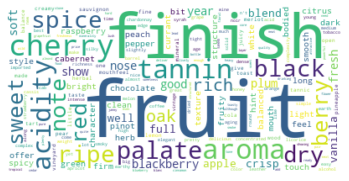

In [460]:
#Plot only with tokenized words:
#first stemming the words that have the same root. 
stemmer = nltk.stem.WordNetLemmatizer()  
#flatten the nested list of tokens into a long string
text = " ".join(stemmer.lemmatize(token) for token in wordtokens)   
wordcloud1 = WordCloud(collocations = False, background_color = "white").generate(text)
plt.imshow(wordcloud1, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [449]:
##Meichan: Create a frequency distribution for all the nouns in the reviews: 
#Make a list with all the nouns: 
reviewdf1["nouns"] = reviewdf1["nouns"].apply(eval)
nountokens = []
for sublist in reviewdf1["nouns"]:
    for item in sublist:
        nountokens.append(item)
#Count the most frequent 50 words in the dataset: 
noundist = FreqDist(nountokens)
noundist.most_common(20)

[('wine', 88260),
 ('flavors', 77815),
 ('fruit', 56053),
 ('finish', 33140),
 ('acidity', 32557),
 ('aromas', 32195),
 ('tannins', 31111),
 ('palate', 28440),
 ('cherry', 26067),
 ('spice', 22030),
 ('notes', 19508),
 ('oak', 18153),
 ('berry', 16106),
 ('%', 15768),
 ('blackberry', 14217),
 ('blend', 13285),
 ('vanilla', 13209),
 ('plum', 13032),
 ('years', 12759),
 ('fruits', 12147)]

In [450]:
print("The number of noun tokens in this review dataset is:", len(nountokens))   

The number of noun tokens in this review dataset is: 1980620


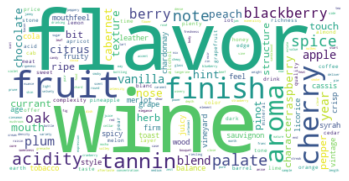

In [461]:
#Plot a word cloud with only nouns
nountext = " ".join(stemmer.lemmatize(token) for token in nountokens)   
wordcloud2 = WordCloud(collocations = False, background_color = "white").generate(nountext)
plt.imshow(wordcloud2, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [451]:
##Meichan: Create a frequency distribution for all the adjectives in the reviews: 
reviewdf1["adjectives"] = reviewdf1["adjectives"].apply(eval)
adjtokens = []
for sublist in reviewdf1["adjectives"]:
    for item in sublist:
        adjtokens.append(item)
#Count the most frequent 20 words in the dataset: 
adjdist = FreqDist(adjtokens)
adjdist.most_common(20)

[('black', 24590),
 ('dry', 21426),
 ('rich', 20957),
 ('red', 18328),
 ('soft', 17710),
 ('fresh', 17511),
 ('good', 17258),
 ('ripe', 17069),
 ('sweet', 16854),
 ('white', 11852),
 ('green', 10642),
 ('full', 9017),
 ('bright', 8884),
 ('dark', 7756),
 ('clean', 7709),
 ('light', 7656),
 ('tannic', 7508),
 ('fine', 7370),
 ('more', 7210),
 ('great', 6879)]

In [452]:
print("The number of adjective tokens in this review dataset is:", len(adjtokens))   

The number of adjective tokens in this review dataset is: 981885


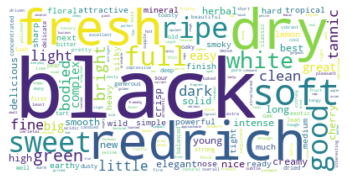

In [462]:
adjtext = " ".join(stemmer.lemmatize(token) for token in adjtokens)   
wordcloud3 = WordCloud(collocations = False, background_color = "white").generate(adjtext)
plt.imshow(wordcloud3, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [453]:
##Meichan: Bigram for the tokenized reviews: 
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures() #call the function ntlk.collocations.BigramAssocMeasures bigram_measures
finder = BigramCollocationFinder.from_words(wordtokens) 
scored = finder.score_ngrams(bigram_measures.raw_freq) 
#Before applying for any filters, print out the top 30 frequent bigrams
for bscore in scored[:50]:
    print(bscore)

(('black', 'cherry'), 0.00180762153211107)
(('cabernet', 'sauvignon'), 0.0013726417163949037)
(('pinot', 'noir'), 0.0012305541212812058)
(('black', 'fruit'), 0.0009431826865829502)
(('cherry', 'fruit'), 0.0007865667075107967)
(('sauvignon', 'blanc'), 0.0007836610307191056)
(('black', 'currant'), 0.0007615778871022528)
(('crisp', 'acidity'), 0.0007429815556354294)
(('ripe', 'fruit'), 0.0007206078443394075)
(('berry', 'fruit'), 0.0006947473208933562)
(('tropical', 'fruit'), 0.0006656905529764445)
(('red', 'fruit'), 0.0006642377145805989)
(('firm', 'tannins'), 0.000636924352738702)
(('green', 'apple'), 0.0006357620820220256)
(('black', 'pepper'), 0.000611644964650989)
(('barrel', 'sample'), 0.0005761957077923569)
(('stone', 'fruit'), 0.0005517880227421511)
(('red', 'berry'), 0.0005294143114461292)
(('blackberry', 'cherry'), 0.0005143047921293351)
(('long', 'finish'), 0.0005122708183751514)
(('cabernet', 'franc'), 0.0005084934385459529)
(('nose', 'palate'), 0.0005035537880000778)
(('dark',

In [454]:
for bscore in scored[:20]:
    print(bscore)

(('black', 'cherry'), 0.00180762153211107)
(('cabernet', 'sauvignon'), 0.0013726417163949037)
(('pinot', 'noir'), 0.0012305541212812058)
(('black', 'fruit'), 0.0009431826865829502)
(('cherry', 'fruit'), 0.0007865667075107967)
(('sauvignon', 'blanc'), 0.0007836610307191056)
(('black', 'currant'), 0.0007615778871022528)
(('crisp', 'acidity'), 0.0007429815556354294)
(('ripe', 'fruit'), 0.0007206078443394075)
(('berry', 'fruit'), 0.0006947473208933562)
(('tropical', 'fruit'), 0.0006656905529764445)
(('red', 'fruit'), 0.0006642377145805989)
(('firm', 'tannins'), 0.000636924352738702)
(('green', 'apple'), 0.0006357620820220256)
(('black', 'pepper'), 0.000611644964650989)
(('barrel', 'sample'), 0.0005761957077923569)
(('stone', 'fruit'), 0.0005517880227421511)
(('red', 'berry'), 0.0005294143114461292)
(('blackberry', 'cherry'), 0.0005143047921293351)
(('long', 'finish'), 0.0005122708183751514)


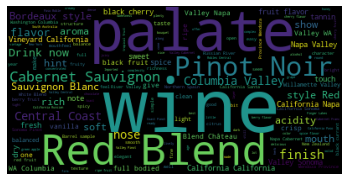

In [463]:
'''Erica: Plot word clouds with noun phrases and adjective categories'''
import numpy as np
from PIL import Image

#Wordcloud from dataframe column
text=open('winemag-data_first150k.csv', 'r').read()

wc = WordCloud(stopwords=STOPWORDS,
               ).generate(text)
plt.imshow(wc)
plt.axis("off")
plt.show()

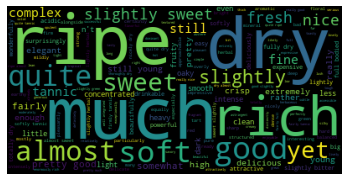

In [464]:
#Wordcloud for adjective phrases *BLACK*

# create a textlist of all adjective phrases
adjphtext = " ".join(review for review in reviewdf1.adjphrases.astype(str))


adjwc = WordCloud(stopwords=STOPWORDS,
               ).generate(adjphtext)
plt.imshow(adjwc)
plt.axis("off")
plt.show()

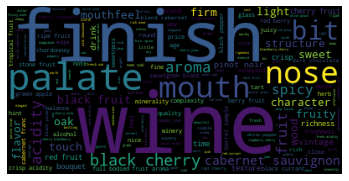

In [465]:
#Wordcloud for noun phrases *BLACK*

# create a textlist of all noun phrases
text = " ".join(review for review in reviewdf1.nounphrases.astype(str))

wc = WordCloud(stopwords=STOPWORDS,
               ).generate(text)
plt.imshow(wc)
plt.axis("off")
plt.show()

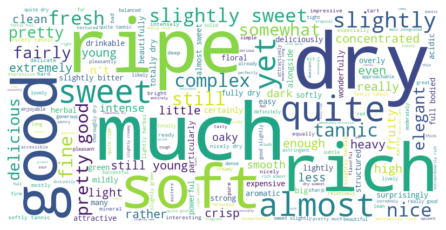

In [466]:
#Wordcloud for adjective phrases *WHITE*

# create a textlist of all adjective phrases
textadj = " ".join(review for review in reviewdf1.adjphrases.astype(str))

#set stopwords
stopwords = set(STOPWORDS)

#create wordcloud for country
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(textadj)

#display image
plt.axis("off")

plt.tight_layout(pad=0)

# store to file

wc.to_file("adj_phrases.png")

#make image appear smooth
plt.imshow(wordcloud, interpolation='bilinear')

plt.show()

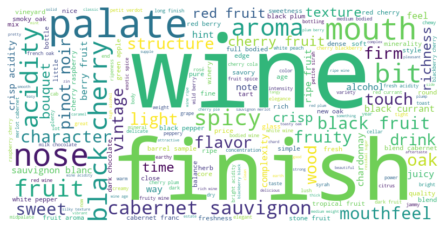

In [467]:
#Wordcloud for noun phrases *WHITE*

# create a textlist of all noun phrases
textnoun = " ".join(review for review in reviewdf1.nounphrases.astype(str))

#set stopwords
stopwords = set(STOPWORDS)

#create wordcloud for country
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(textnoun)

#display image
plt.axis("off")

plt.tight_layout(pad=0)

# store to file

wc.to_file("noun_phrases.png")

#make image appear smooth
plt.imshow(wordcloud, interpolation='bilinear')

plt.show()

In [468]:
# converting png image to a numpy array for wine glass and bottle image

glass_bottle = np.array(Image.open("wine bottle and glass.jpeg"))
glass_bottle

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

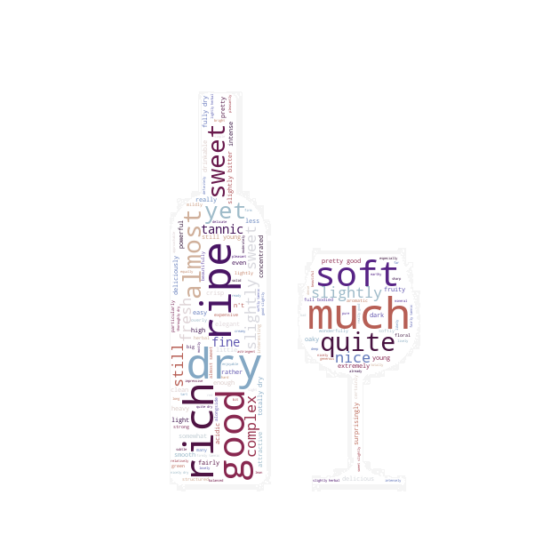

In [469]:

# Create a word cloud image for adjective phrases in wine glass and bottle image

wc = WordCloud(background_color="white", max_words=250, mask=glass_bottle,
               stopwords=stopwords, contour_width=1, contour_color='whitesmoke', colormap = "twilight")

# Generate a wordcloud

wc.generate(textadj)

# store to file

wc.to_file("glass_bottle.png")

# show

plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


In [470]:
# converting png image to a numpy array for wine bottles image

wine_bottles = np.array(Image.open("wine bottles.jpeg"))
wine_bottles

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

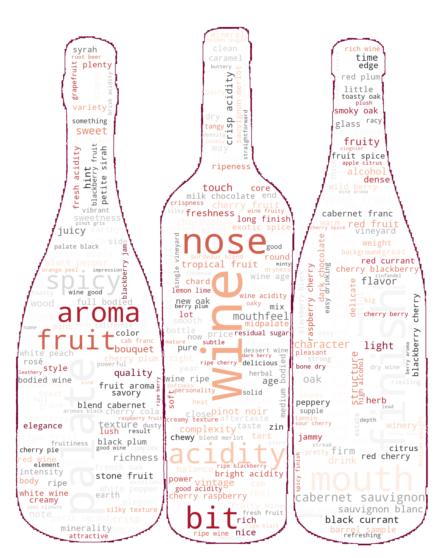

In [471]:
# Create a word cloud image for noun phrases in wine and bottle image

wc = WordCloud(background_color="white", max_words=300, mask=wine_bottles,
               stopwords=stopwords, contour_width=3, contour_color='#770033', colormap = "RdGy")

# Generate a wordcloud

wc.generate(textnoun)

# store to file

wc.to_file("wine_bottles.png")

# show

plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [472]:
'''Nicholas: Step 3: create a descriptive analysis of the ratings based on the prices, countries, and varieties of wines '''
from datetime import datetime

#Nicholas: creating groupby variables
Countrywine = reviewdf1.groupby('Country')
Pts_price_wine = reviewdf1.groupby(['Points', 'Price'])
pts_wine = reviewdf1.groupby('Points')
price_wine = reviewdf1.groupby('Price')
wine_type = reviewdf1.groupby('Variety')

In [473]:
#Nicholas: testing get_group function
#Can now search up any country and its whole row
Countrywine.get_group('US-France')

,Country,Review,Points,Price,Variety,TaggedReview,nouns,adjectives,word_token_cleaned,adjphrases,nounphrases
144048,US-France,"defies categorization, in more ways than one. ...",88,50.0,Viognier,"[('defies', 'NNS'), ('categorization', 'NN'), ...","[defies, categorization, ways, wine, venture, ...","[more, joint, cold, morgan, 50-50, sunny, yell...","[defies, categorization, ways, one, joint, ven...",['extraordinarily rich '],"['a great job ', 'schug ', 'rich cab ', 'ripe ..."


There are 48 countries and the first five on the list are: Spain, US, France, Italy, New Zealand



Text(0, 0.5, 'Frequency of entries')

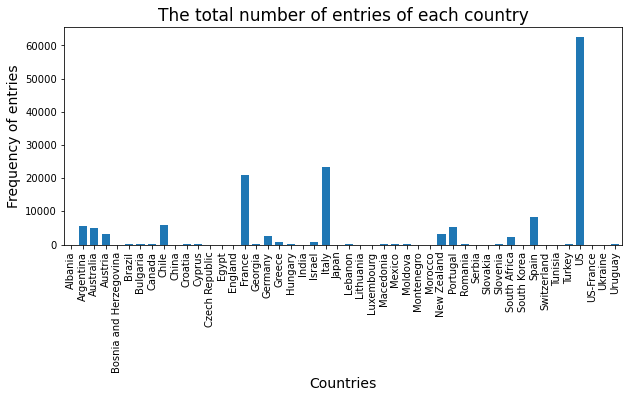

In [474]:
#Meichan: Visusalization of the dataset grouped by Countries
print("There are {} countries and the first five on the list are: {}\n".format(len(reviewdf1.Country.unique()), ", ".join(reviewdf1.Country.unique()[0:5])))

wine_country = pd.crosstab(index = reviewdf1['Country'], columns = 'count')
plt.rcParams["figure.figsize"][0] = 10
plt.rcParams["figure.figsize"][1] = 4
wine_country['count'].plot(kind = 'bar',width= 0.7)
plt.title("The total number of entries of each country", fontsize = 17)
plt.xlabel("Countries", fontsize = 14)
plt.ylabel("Frequency of entries", fontsize = 14)

Findings: The bar graph showed that almost all the countries with less than 10000 reviews. 
Only 3 countries have over 20000 reviews, namely USA, over 60000 entries; France and Italy with over 20000 reviews. 
While Arbania seems to get the minimum entries in the dataset

In [476]:
#Nicholas: lowest points
lowest_pts = reviewdf1.groupby('Country')['Points'].min()
lowest_pts[:10]

Country
Albania                   88
Argentina                 80
Australia                 80
Austria                   81
Bosnia and Herzegovina    83
Brazil                    81
Bulgaria                  80
Canada                    82
Chile                     80
China                     82
Name: Points, dtype: int64

In [477]:
#Nicholas: highest points
highest_pts = reviewdf1.groupby('Country')['Points'].max()
highest_pts[:10]

Country
Albania                    88
Argentina                  97
Australia                 100
Austria                    98
Bosnia and Herzegovina     88
Brazil                     88
Bulgaria                   90
Canada                     93
Chile                      95
China                      82
Name: Points, dtype: int64

In [478]:
#Nicholas: testing get_group function
#Grouped by points and price
Pts_price_wine.first()

Country                                             Review  \
Points Price                                                                  
80     5.0     Argentina  candied plum and red berry aromas smell like r...   
       6.0        France  light in body and flavor, this southern france...   
       7.0         Spain  an unclean nose smells cheesy. this is flabby ...   
       8.0      Portugal  this is a light, fruity and off-dry wine. it h...   
       9.0         Spain  of all the cavas made by freixenet, this oddly...   
...                  ...                                                ...   
100    245.0          US  impossibly aromatic. hard to imagine greater c...   
       300.0   Australia  not a cellar selection in the traditional sens...   
       460.0       Italy  a perfect wine from a classic vintage, the 200...   
       848.0      France  full of ripe fruit, opulent and concentrated, ...   
       1400.0     France  a wine that has created its own universe. it h...   

                                  Variety  \
Points Price                                
80     5.0                         Malbec   
       6.0             Cabernet Sauvignon   
       7.0             Shiraz-Tempranillo   
       8.0               Portuguese White   
       9.0                Sparkling Blend   
...                                   ...   
100    245.0               Cabernet Blend   
       300.0                       Muscat   
       460.0                       Merlot   
       848.0   Bordeaux-style White Blend   
       1400.0                  Chardonnay   

                                                    TaggedReview  \
Points Price                                                       
80     5.0     [('candied', 'VBN'), ('plum', 'NN'), ('and', '...   
       6.0     [('light', 'NN'), ('in', 'IN'), ('body', 'NN')...   
       7.0     [('an', 'DT'), ('unclean', 'JJ'), ('nose', 'NN...   
       8.0     [('this', 'DT'), ('is', 'VBZ'), ('a', 'DT'), (...   
       9.0     [('of', 'IN'), ('all', 'PDT'), ('the', 'DT'), ...   
...                                                          ...   
100    245.0   [('impossibly', 'RB'), ('aromatic', 'JJ'), ('....   
       300.0   [('not', 'RB'), ('a', 'DT'), ('cellar', 'JJ'),...   
       460.0   [('a', 'DT'), ('perfect', 'JJ'), ('wine', 'NN'...   
       848.0   [('full', 'JJ'), ('of', 'IN'), ('ripe', 'JJ'),...   
       1400.0  [('a', 'DT'), ('wine', 'NN'), ('that', 'WDT'),...   

                                                           nouns  \
Points Price                                                       
80     5.0     [plum, berry, licorice, flavors, sourness, ast...   
       6.0     [light, body, flavor, france, wine, aromas, be...   
       7.0     [nose, smells, cheesy, acidity, flavors, spunk...   
       8.0       [fruity, wine, splashes, lemon, citrus, finish]   
       9.0     [cavas, freixenet, spumante, nose, hints, lych...   
...                                                          ...   
100    245.0   [perfume, mingling, oak, cassis, cherries, coc...   
       300.0   [selection, sense, aging, wine, material, year...   
       460.0   [wine, vintage, masseto, %, merlot, vineyard, ...   
       848.0   [fruit, opulent, wine, line, acidity, fruits, ...   
       1400.0  [wine, universe, unique, softness, allies, pur...   

                                                      adjectives  \
Points Price                                                       
80     5.0                                   [red, red, raisiny]   
       6.0                            [southern, everyday, much]   
       7.0        [unclean, flabby, flat, sugary, soft, overall]   
       8.0                        [light, off-dry, sweet, crisp]   
       9.0        [sweet, weakest, briny, pickled, banana, faux]   
...                                                          ...   
100    245.0   [aromatic, hard, greater, claret, refined, smo...   
       300.0   [cella

In [479]:
#Nicholas: lowest price
lowest_price = reviewdf1.groupby('Country')['Price'].min()
highest_price = reviewdf1.groupby('Country')['Price'].max()
print(lowest_price[:10])
print(highest_price[:10])

Country
Albania                   20.0
Argentina                  4.0
Australia                  5.0
Austria                    8.0
Bosnia and Herzegovina    12.0
Brazil                    11.0
Bulgaria                   7.0
Canada                    12.0
Chile                      5.0
China                      7.0
Name: Price, dtype: float64
Country
Albania                     20.0
Argentina                  250.0
Australia                  850.0
Austria                   1100.0
Bosnia and Herzegovina      13.0
Brazil                      35.0
Bulgaria                    28.0
Canada                     145.0
Chile                      400.0
China                       27.0
Name: Price, dtype: float64


In [480]:
##Meichan: Get the varities of wine and plot their barchart

print("There are {} varities of wine and the first five are {}\n".format(len(reviewdf1.Variety.unique()), ", ".join(reviewdf1.Variety.unique()[0:5])))


winevariety = pd.crosstab(index = reviewdf1['Variety'], columns = 'count').sort_values('count' , ascending = False)
print("The top 10 wine types are:", winevariety[:10])




There are 632 varities of wine and the first five are Tinta de Toro, Sauvignon Blanc, Pinot Noir, Provence red blend, Friulano

The top 10 wine types are: col_0                     count
Variety                        
Chardonnay                14482
Pinot Noir                14288
Cabernet Sauvignon        12799
Red Blend                 10061
Bordeaux-style Red Blend   7347
Sauvignon Blanc            6320
Syrah                      5825
Riesling                   5524
Merlot                     5070
Zinfandel                  3799


Text(0, 0.5, 'The number of wine variety presented')

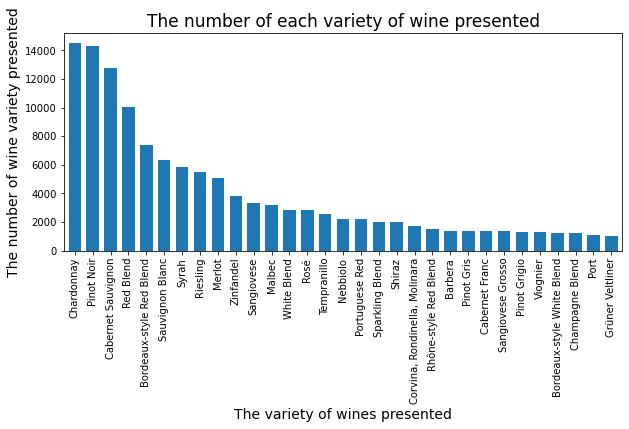

In [481]:
##Plot only the ones that are over 1000 reviews. 
wines_var = winevariety[winevariety['count'] > 1000]
plt.rcParams["figure.figsize"][0] = 10
plt.rcParams["figure.figsize"][1] = 4
wines_var['count'].plot(kind = 'bar', width = 0.7)
plt.title("The number of each variety of wine presented", fontsize= 17)
plt.xlabel("The variety of wines presented", fontsize = 14)
plt.ylabel("The number of wine variety presented", fontsize = 14)

In [482]:
#Nicholas: testing get_group function
#Grouped by specific wine type
wine_type.get_group('Chardonnay')

,Country,Review,Points,Price,Variety,TaggedReview,nouns,adjectives,word_token_cleaned,adjphrases,nounphrases
14,US,"first made in 2006, this succulent luscious ch...",95,90.0,Chardonnay,"[('first', 'RB'), ('made', 'VBN'), ('in', 'IN'...","[succulent, chardonnay, minerality, core, butt...","[luscious, rich, endless, subtle, biodynamic]","[first, made, succulent, luscious, chardonnay,...",['seductively silky '],"['this blockbuster ', 'powerhouse ', 'pie ', '..."
22,US,the apogee of this ambitious winery's white wi...,95,60.0,Chardonnay,"[('the', 'DT'), ('apogee', 'NN'), ('of', 'IN')...","[apogee, winery, wine, efforts, bottling, barr...","[ambitious, white, marcona, white, lemony, bro...","[apogee, ambitious, winery, white, efforts, bo...",[],"['san jose-based producer ', 'adam ', 'comarti..."
24,New Zealand,"yields were down in 2015, but intensity is up,...",94,57.0,Chardonnay,"[('yields', 'NNS'), ('were', 'VBD'), ('down', ...","[yields, intensity, potential, smoke, outlines...","[medium-bodied, silky, least, hickory, white, ...","[yields, intensity, giving, medium-bodied, sil...",[],"['bergström ', 'a shea ', 'designate ', 'inten..."
30,US,"steely and perfumed, this wine sees only 20% n...",90,37.0,Chardonnay,"[('steely', 'RB'), ('and', 'CC'), ('perfumed',...","[wine, %, oak, apple, lemon, pith, veer, grape...","[new, french, fresh]","[steely, perfumed, sees, new, french, oak, rem...",[],"['underbrush ', 'earth ', 'menthol ', 'plum ',..."
33,US,"the aromas entice with notes of wet stone, hon...",90,42.0,Chardonnay,"[('the', 'DT'), ('aromas', 'JJ'), ('entice', '...","[entice, notes, wet, stone, honeysuckle, chamo...","[aromas, generous, fine]","[aromas, entice, notes, wet, stone, honeysuckl...",[],"['floor ', 'soil ', 'mature ', 'berry ', 'a wh..."
...,...,...,...,...,...,...,...,...,...,...,...
150878,US,here's a nice everyday drinking wine with some...,83,10.0,Chardonnay,"[('here', 'RB'), (""'s"", 'VBZ'), ('a', 'DT'), (...","[drinking, wine, richness, chardonnay, grapes,...","[nice, everyday, real, ripe, toasty, peach-fla...","[nice, everyday, drinking, real, richness, rip...",['rather green '],"['a heavy mantle ', 'not-too-subtle oak ', 'th..."
150879,Chile,orangey aromas wrapped in not very subtle oak ...,83,14.0,Chardonnay,"[('orangey', 'JJ'), ('aromas', 'NN'), ('wrappe...","[aromas, oak, weight, wine, simple, bit, flavo...","[orangey, subtle, open, light-to-medium, one-d...","[orangey, aromas, wrapped, subtle, oak, open, ...",[],"['strawberry ', 'grapefruit ', 'mingle ', 'the..."
150881,Chile,the pineapple and lemon aromas and flavors in ...,82,13.0,Chardonnay,"[('the', 'DT'), ('pineapple', 'NN'), ('and', '...","[pineapple, aromas, flavors, wine, spark, medi...","[lemon, alive, uninspired, more]","[pineapple, lemon, aromas, seem, lack, spark, ...",['slightly woody '],"['this light ', 'weight ', 'cabernet ', 'the r..."
150884,Chile,"wearing a heavy mantle of rather green, not-to...",82,12.0,Chardonnay,"[('wearing', 'VBG'), ('a', 'DT'), ('heavy', 'J...","[mantle, oak, fruit, wine, apple, notes, wine,...","[heavy, green, not-too-subtle, earthy]","[wearing, heavy, mantle, rather, green, not-to...",['rapidly earthy '],"['fruit ', 'the aroma ', 'tomato ', 'rhubarb '..."


AxesSubplot(0.125,0.125;0.775x0.755)


count    150924.000000
mean         87.888474
std           3.222233
min          80.000000
25%          86.000000
50%          88.000000
75%          90.000000
max         100.000000
Name: Points, dtype: float64

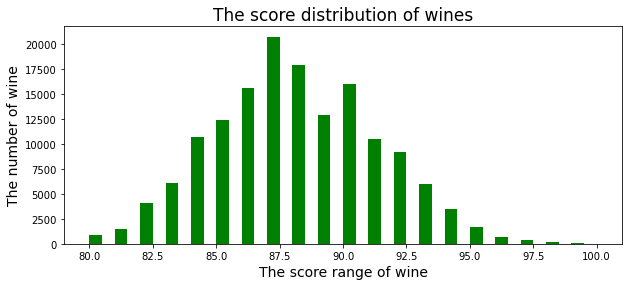

In [483]:
#Meichan: Understand the point distribution of the data, as this is one of the important parameters we will use to descide the the classification for us. 
#The assumption is that So, it is obviously preassumed that the higher the rating points of the wine the better will be its quality (hence better/more positive reviews) and somewhat same relation is applied with the price (the higher price/the more positive the review)
point_hist = reviewdf1['Points'].hist(grid = False, bins = 40,color = 'green')
print(point_hist)
plt.title("The score distribution of wines", fontsize= 17)
plt.xlabel("The score range of wine", fontsize = 14)
plt.ylabel("The number of wine", fontsize = 14)

#Also, obtain the descriptive analysis of the points: 
reviewdf1['Points'].describe()

Meichan suggested that: 
It is clearly that the wine review points in this dataset is somewhat normally distributed. 
It has its peak between around 87-89. 
The mean of the points given to the varieties were around 87.9. 
The maximum was 100 which was very few.
The minimum was 80 which was again very few. 
So None of the wine quality was ever given a below 80 mark which proves most of the wines were above average for the reviewer. 
And the Standard deviation of 3.22 suggests that the points given to each wine was 88 (approx.) +/- 3 which means anything ranging from 85 to 91 which is a very good score.

Based on the results, we could divide the variable of Points (continuous) into a categorical variable when conducting classification tasks: 

80 to 85 points = "average"
85 to 90 points = "good"
90 to 95 points = "great"
95 to 100 points = "excellent"'''

AxesSubplot(0.125,0.125;0.775x0.755)


count    150924.000000
mean         31.939069
std          34.836879
min           4.000000
25%          16.000000
50%          22.000000
75%          38.000000
max        2300.000000
Name: Price, dtype: float64

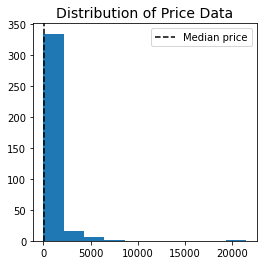

In [485]:
##Meichan: Another important numeric parameter is "Points" and we will do some descriptive anlaysis
price = pd.crosstab(index = reviewdf1['Price'], columns = 'count').sort_values(by = 'count', ascending = False)
plt.rcParams['figure.figsize'][0] = 4
plt.rcParams['figure.figsize'][1] = 4
price_hist = price['count'].hist(grid = False)

#Eryka: Added median axis vertical line and customized colors
plt.title("Distribution of Price Data", fontsize= 14)
median_price = np.median(reviewdf1['Price'])
plt.axvline(median_price, color="black", ls="--", label="Median price")
plt.legend();
print(price_hist)


reviewdf1['Price'].describe()

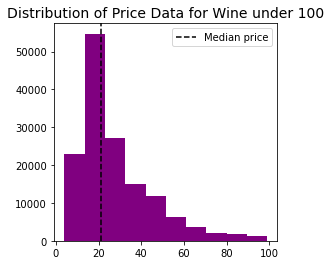

In [486]:
#Meichan: if we narrow down the scope of the price to include wines under 100 dollars:
price_max = reviewdf1[reviewdf1['Price'] < 100]['Price']
price_max.hist(grid = False, color = 'purple')

#Eryka: Added title, median axis vertical line and customized colors
plt.title("Distribution of Price Data for Wine under 100", fontsize= 14)
median_price = np.median(price_max)
plt.axvline(median_price, color="black", ls="--", label="Median price")
plt.legend();

Findings: Unlike the point, Price is highly skewed, which we already know at the data cleaning stage
Most of the price seems to be on the lower end between 4 - 100 dollars.
The most common price point for the wines in the dataset is around 20 dollars
So based on the descriptive analysis of the Price, the mean is around 30 which is much below 50.
The data also has a very high standard deviation i.e. 34 so the prices actually vary from 60 to 4;
This can also be seen from the graph as it is highly skewed. 
We have hardly the prices going to 100's So we can divide up the groups as follows:

0-10
10-20
20-30
30-50
50-100
Above 100


In [488]:
'''Meichan: Step 5: Classification task preparation'''

#Meichan: Based on the descriptive data analysis of wine prices and points, we can create two more categorical variables to make our classification tasks easier.

#First, we group the Point datapoints based on the following criteria and create a new column called Quality
reviewdf1.loc[(reviewdf1['Points'] > 80) & (reviewdf1['Points']<=85), 'Quality'] = 'Average'
reviewdf1.loc[(reviewdf1['Points'] > 85) & (reviewdf1['Points'] <=90), 'Quality'] = 'Good'
reviewdf1.loc[(reviewdf1['Points'] > 90) & (reviewdf1['Points'] <=95), 'Quality'] = 'Great'
reviewdf1.loc[(reviewdf1['Points'] > 95) & (reviewdf1['Points']<=100), 'Quality'] = 'Excellent'
reviewdf1 = reviewdf1[reviewdf1['Quality'].apply(lambda x: type(x) == str)]


In [490]:
#Next, we group the Price datapoints based on the following criteria and create a new column called Price_val
reviewdf1.loc[(reviewdf1['Price'] > 0) &  (reviewdf1['Price'] <=10) , 'Price_val'] = '0-10'
reviewdf1.loc[(reviewdf1['Price'] > 10) & (reviewdf1['Price'] <=20) , 'Price_val'] = '10-20'
reviewdf1.loc[(reviewdf1['Price'] > 20) & (reviewdf1['Price'] <=30) , 'Price_val'] = '20-30'
reviewdf1.loc[(reviewdf1['Price'] > 30) & (reviewdf1['Price'] <=50) , 'Price_val'] = '30-50'
reviewdf1.loc[(reviewdf1['Price'] > 50) & (reviewdf1['Price'] <=100) , 'Price_val'] = '50-100'
reviewdf1.loc[(reviewdf1['Price'] > 100), 'Price_val'] = 'Above 100'

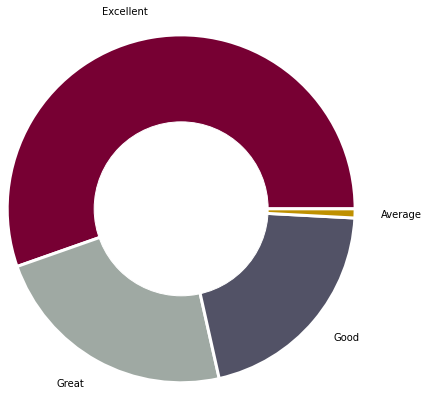

Good         83083
Average      34707
Great        30972
Excellent     1264
Name: Quality, dtype: int64


In [491]:
#Eryka: Create pie (donut) graph for Quality

values = reviewdf2['Quality'].value_counts()
labels = reviewdf2['Quality'].unique().tolist()

# Create a set of colors
colors = ['#770033', '#9fa9a3', '#525266', '#bf9000', '#4F6272']

plt.pie(values, labels=labels, radius=2, labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, colors = colors);


my_circle = plt.Circle((0,0), 1, color = 'white')
p = plt.gcf()
p.gca().add_artist(my_circle)


plt.show()
print(values)

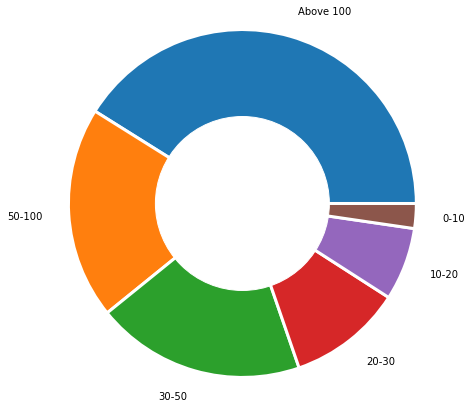

10-20        61651
20-30        29610
30-50        29194
50-100       15940
0-10         10167
Above 100     3464
Name: Price_val, dtype: int64


In [492]:
#Meichan: A similar pie chart for Price_val
values = reviewdf2['Price_val'].value_counts()
labels = reviewdf2['Price_val'].unique().tolist()


plt.pie(values, labels=labels, radius=2, labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' });

my_circle = plt.Circle((0,0), 1, color = 'white')
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.show()
print(values)

In [493]:
#Save the categorized data into the new dataset and all the classification tasks will be based on this dataset. 

reviewdf1.to_csv("winereviewcategorized.csv")

In [494]:
reviewdf1.head()

,Country,Review,Points,Price,Variety,TaggedReview,nouns,adjectives,word_token_cleaned,adjphrases,nounphrases,Quality,Price_val
0,Spain,"ripe aromas of fig, blackberry and cassis are ...",96,110.0,Tinta de Toro,"[('ripe', 'JJ'), ('aromas', 'NN'), ('of', 'IN'...","[aromas, fig, blackberry, cassis, slathering, ...","[ripe, oaky, full, intense, rich, black, heady]","[ripe, aromas, fig, blackberry, cassis, soften...",['tremendously delicious '],"['mac ', 'watson ', 'the memory ', 'a wine ', ...",Excellent,Above 100
1,US,mac watson honors the memory of a wine once ma...,96,90.0,Sauvignon Blanc,"[('mac', 'NN'), ('watson', 'NN'), ('honors', '...","[mac, watson, memory, wine, mother, gold, colo...","[delicious, balanced, complex, white, dark, pe...","[mac, watson, honors, memory, made, mother, tr...",[],"['% ', 'new french oak ', 'fruit ', 'ponzi ', ...",Excellent,50-100
2,US,"this spent 20 months in 30% new french oak, an...",96,65.0,Pinot Noir,"[('this', 'DT'), ('spent', 'VBD'), ('20', 'CD'...","[months, %, oak, fruit, ponzi, aurora, abetina...","[new, french, aromatic, dense, toasty, aromas,...","[spent, months, new, french, oak, incorporates...",[],"['the top wine ', 'la bégude ', 'point ', 'the...",Excellent,50-100
3,France,"this is the top wine from la bégude, named aft...",95,66.0,Provence red blend,"[('this', 'DT'), ('is', 'VBZ'), ('the', 'DT'),...","[wine, bégude, point, vineyard, feet, structur...","[top, la, highest, considerable, extra, tari]","[top, la, bégude, named, highest, point, viney...",[],"['dense ', 'pure ', 'the opening ', 'bell ', '...",Great,50-100
4,Spain,"deep, dense and pure from the opening bell, th...",95,73.0,Tinta de Toro,"[('deep', 'RB'), (',', ','), ('dense', 'NN'), ...","[dense, pure, opening, bell, toro, winner, aro...","[dark, ripe, black, cool, feels, toasty, heady...","[deep, dense, pure, opening, bell, toro, winne...","['slightly gritty ', 'highly impressive ']","['gritty black-fruit ', 'a sweet note ', 'past...",Great,50-100


Step 4: Classification tasks with the dataset: collaborated by Meichan and Nicholas
In this section, we have only included the higher performance modeling we had worked on. 
Ones with only 10 - 20% accuracy rate were excluded from this coding sheet.
In this section, we presented the following models:
- Naive Bayes models: (Nicholas initiated this model)
   - price and points (Nicholas)
   - tokenized words, adjectives, nouns v.s. quality (wine points categories) respectively (3 models by Meichan): among which tokenized word has the best model accuracy of 67% to predict wine quality. 
   - tokenized words, adjectives v.s. price_val (price categories) respectively (2 models by Meichan): again, tokenized words has the best accuracy of 48% to predict the price. 
   - tokenized words, adjectives v.s. top 4 varieties of wines (each of which over 10k reviews) and this is the best model we did so far with 88% accuracy. 

- SVM models: (Nicholas initiated this model too AND sadly it took too long) 

In [297]:
import nltk
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split as tts
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

In [345]:
#Our model using multinomialNB and Tfidf vectorizer
model2 = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [608]:
#Nicholas: Test run with price_val and quality to see if the model we built run successfully wothout error messages.

#Use variety as the input (x) and quality (y) as the output for classification: 
x = reviewdf1.Variety
y = reviewdf1.Quality
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.30, random_state=1, stratify=y)

#Train the data with model 2 and output the scores. 
training = model2.fit(x_train, y_train)
predictedd = model2.predict(x_test)
scores_qual = 100 * model2.score(x_test,y_test)

In [609]:
#Obtain the cross-validation score for the test model with 10 kfolds. 
scores = cross_val_score(model2, x_train, y_train, cv = 10, scoring='accuracy')
print('Cross-validation scores:{}'.format(scores))
print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Cross-validation scores:[0.55617978 0.55418016 0.55656066 0.55741763 0.55541802 0.55427538
 0.55513236 0.55932203 0.55461385 0.55823255]
Average cross-validation score: 0.5561


In [610]:
#Obtain the cross-validation score for the test model with 5 kfolds. 
scores2 = cross_val_score(model2, x_train, y_train, cv = 5, scoring='accuracy')
print('Cross-validation scores:{}'.format(scores2))
print('Average cross-validation score: {:.4f}'.format(scores2.mean()))

Cross-validation scores:[0.55517997 0.55665588 0.55517997 0.55720611 0.55587297]
Average cross-validation score: 0.5560


In [611]:
#Print out the accuracy score, precision, recall, f1-score, and support results for the test model
print("The score of Mulitnomial Naive Bayes for the quality of wine is {} %".format(scores_qual))
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, predictedd)))
print(classification_report(y_test, predictedd))

The score of Mulitnomial Naive Bayes for the quality of wine is 55.57234269463207 %
Model accuracy score: 0.5557
              precision    recall  f1-score   support

     Average       0.56      0.03      0.05     10412
   Excellent       0.00      0.00      0.00       379
        Good       0.56      0.98      0.71     24925
       Great       0.48      0.04      0.08      9292

    accuracy                           0.56     45008
   macro avg       0.40      0.26      0.21     45008
weighted avg       0.54      0.56      0.42     45008



In [612]:
#Print out the confusion metrix for this test model: 
cm = confusion_matrix (y_test, predictedd)
cm

array([[  286,     0, 10076,    50],
       [    0,     0,   370,     9],
       [  214,     6, 24317,   388],
       [    7,     0,  8876,   409]])

Nicholas: Our experiment seem to be running ok and there was no error messages, Therefore, we will be using this model for our actual modeling in the section below. 

In [614]:
'''Meichan conducted the following section: classification tasks with tokenized wine review with wine Quality, wine Price_val, and wine varieties
The first three models are to test how wine reviews(tokenized words, adjs, and nouns) predict wine quality (average, good, great, excellent)'''

#Model 1: use tokenized words to predict wine quality: 
classifydf = pd.read_csv("winereviewcategorized.csv", sep=",")
classifydf1 = classifydf.loc[:, ["word_token_cleaned", "Quality"]]

In [615]:
#This dataset only included the tokenized words and quality for classification
classifydf1.head()

,word_token_cleaned,Quality
0,"['ripe', 'aromas', 'fig', 'blackberry', 'cassi...",Excellent
1,"['mac', 'watson', 'honors', 'memory', 'made', ...",Excellent
2,"['spent', 'months', 'new', 'french', 'oak', 'i...",Excellent
3,"['top', 'la', 'bégude', 'named', 'highest', 'p...",Great
4,"['deep', 'dense', 'pure', 'opening', 'bell', '...",Great


In [616]:
#Split the train test sets for both x and y variables
x1 = classifydf1.word_token_cleaned
y1 = classifydf1.Quality
x_train1, x_test1, y_train1, y_test1 = tts(x1, y1, test_size=0.30, random_state=1, stratify=y1)

In [617]:
#Train and predict with the train test dataset. To obtain the accuracy score of the model 
training1 = model2.fit(x_train1, y_train1)
predicted1 = model2.predict(x_test1)
scores_qual1 = 100 * model2.score(x_test1,y_test1) 

In [618]:
#Calculate the cross-validation score for the model with tokenized reviews and wine quality: 
tokenscores1 = cross_val_score(model2, x_train1, y_train1, cv = 10, scoring='accuracy')
print('Cross-validation scores for the model with tokenized words with kfolds of 10 is:{}'.format(tokenscores1))
print('Average cross-validation score for this model with kfolds of 10 is: {:.4f}'.format(tokenscores1.mean()))

Cross-validation scores for the model with tokenized words with kfolds of 10 is:[0.67682346 0.67453818 0.67396686 0.6732051  0.67834698 0.6803466
 0.6746334  0.67406208 0.67279307 0.67622131]
Average cross-validation score for this model with kfolds of 10 is: 0.6755


In [619]:
tokenscores2 = cross_val_score(model2, x_train1, y_train1, cv = 5, scoring='accuracy')
print('Cross-validation scores for the model with tokenized words with kfolds of 5 is:{}'.format(tokenscores2))
print('Average cross-validation score for this model with kfolds of 5 is: {:.4f}'.format(tokenscores2.mean()))

Cross-validation scores for the model with tokenized words with kfolds of 5 is:[0.67034851 0.67144353 0.67382403 0.67038042 0.67052326]
Average cross-validation score for this model with kfolds of 5 is: 0.6713


In [620]:
print("The accuracy score of Mulitnomial Naive Bayes model for the quality of wine with word tokens is {} %".format(scores_qual1))
print('Model accuracy score with tokens to predict the quality of wine is: {0:0.4f}'.format(accuracy_score(y_test1, predicted1)))
print(classification_report(y_test1, predicted1))

#Trouble shooting:https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi

The accuracy score of Mulitnomial Naive Bayes model for the quality of wine with word tokens is 67.75017774617845 %
Model accuracy score with tokens to predict the quality of wine is: 0.6775


/Users/meichanhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Average       0.87      0.39      0.54     10412
   Excellent       0.00      0.00      0.00       379
        Good       0.64      0.96      0.77     24925
       Great       0.78      0.27      0.41      9292

    accuracy                           0.68     45008
   macro avg       0.58      0.40      0.43     45008
weighted avg       0.72      0.68      0.63     45008



/Users/meichanhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/meichanhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [621]:
#Print out the confusion matrix for modeling wine quality with tokenized words
wordcm = confusion_matrix (y_test, predicted)
wordcm

array([[ 4023,     0,  6374,    15],
       [    0,     0,   107,   272],
       [  584,     0, 23930,   411],
       [    3,     0,  6749,  2540]])

Text(15.0, 0.5, 'predicted labels')

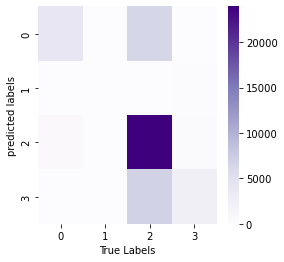

In [622]:
#Headmap1 for confusion metrix 
sns.heatmap(wordcm, fmt='', cmap= 'Purples')
plt.xlabel('True Labels')
plt.ylabel('predicted labels')

In [623]:
#Meichan: model 2: next I tested the adj tokens only to predict wine quality:
#Using adjs for the count vectorizer and quality for labeling:
classifydf2 = classifydf.loc[:, ["adjectives", "Quality"]]
classifydf2.head()

,adjectives,Quality
0,"['ripe', 'oaky', 'full', 'intense', 'rich', 'b...",Excellent
1,"['delicious', 'balanced', 'complex', 'white', ...",Excellent
2,"['new', 'french', 'aromatic', 'dense', 'toasty...",Excellent
3,"['top', 'la', 'highest', 'considerable', 'extr...",Great
4,"['dark', 'ripe', 'black', 'cool', 'feels', 'to...",Great


In [624]:
#Split the train/test set using 70:30 sample size for adjectives and quality
x2 = classifydf2.adjectives
y2 = classifydf2.Quality
x_train2, x_test2, y_train2, y_test2 = tts(x2, y2, test_size=0.30, random_state=1, stratify=y2)

In [626]:
training2 = model2.fit(x_train2, y_train2)
predicted2 = model2.predict(x_test2)
scores_qual2 = 100 * model2.score(x_test2,y_test2)

In [627]:
adjscores = cross_val_score(model2, x_train2, y_train2, cv = 10, scoring='accuracy')
print('Cross-validation scores for modeling using adjectives with kfolds of 10:{}'.format(adjscores))
print('Average cross-validation score for this second model with 10 kfolds is: {:.4f}'.format(adjscores.mean()))

Cross-validation scores for modeling using adjectives with kfolds of 10:[0.65197105 0.65368501 0.65368501 0.65406589 0.65406589 0.65673205
 0.65844601 0.65406589 0.65298543 0.6558423 ]
Average cross-validation score for this second model with 10 kfolds is: 0.6546


In [628]:
adjscores2 = cross_val_score(model2, x_train2, y_train2, cv = 5, scoring='accuracy')
print('Cross-validation scores for modeling using adjectives with kfolds of 5:{}'.format(adjscores2))
print('Average cross-validation score for this second model with 5 kfolds is: {:.4f}'.format(adjscores2.mean()))

Cross-validation scores for modeling using adjectives with kfolds of 5:[0.65111407 0.65297086 0.65501809 0.65481122 0.65343046]
Average cross-validation score for this second model with 5 kfolds is: 0.6535


In [629]:
print("The score of Mulitnomial Naive Bayes for predicting the quality of wine with adjectives only is {} %".format(scores_qual2))
print('Model accuracy score for this second model is: {0:0.4f}'. format(accuracy_score(y_test2, predicted2)))
print(classification_report(y_test2, predicted2))

The score of Mulitnomial Naive Bayes for predicting the quality of wine with adjectives only is 65.40837184500533 %
Model accuracy score for this second model is: 0.6541


/Users/meichanhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Average       0.80      0.37      0.51     10412
   Excellent       0.00      0.00      0.00       379
        Good       0.63      0.94      0.75     24925
       Great       0.73      0.23      0.35      9292

    accuracy                           0.65     45008
   macro avg       0.54      0.39      0.40     45008
weighted avg       0.68      0.65      0.61     45008



/Users/meichanhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/meichanhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [630]:
#Print out the confusion matrix for modeling wine quality with adjectives
adjcm = confusion_matrix (y_test2, predicted2)
adjcm

array([[ 3886,     0,  6500,    26],
       [    0,     0,   151,   228],
       [  955,     0, 23434,   536],
       [   29,     0,  7144,  2119]])

In [631]:
#Meichan: Model 3: use nouns to predict quality. 
classifydf3 = classifydf.loc[:, ["nouns", "Quality"]]
classifydf3.head()

,nouns,Quality
0,"['aromas', 'fig', 'blackberry', 'cassis', 'sla...",Excellent
1,"['mac', 'watson', 'memory', 'wine', 'mother', ...",Excellent
2,"['months', '%', 'oak', 'fruit', 'ponzi', 'auro...",Excellent
3,"['wine', 'bégude', 'point', 'vineyard', 'feet'...",Great
4,"['dense', 'pure', 'opening', 'bell', 'toro', '...",Great


In [632]:
x3 = classifydf3.nouns
y3 = classifydf3.Quality
x_train3, x_test3, y_train3, y_test3 = tts(x3, y3, test_size=0.30, random_state=1, stratify=y3)

In [633]:
training3 = model2.fit(x_train3, y_train3)
predicted3 = model2.predict(x_test3)
scores_qual3 = 100 * model2.score(x_test3,y_test3)

In [634]:
nounscores = cross_val_score(model2, x_train3, y_train3, cv = 10, scoring='accuracy')
print('Cross-validation scores for modeling using nouns with kfolds of 10:{}'.format(nounscores))
print('Average cross-validation score for this third model with 10 kfolds is: {:.4f}'.format(nounscores.mean()))

Cross-validation scores for modeling using nouns with kfolds of 10:[0.62388117 0.62397639 0.6254999  0.62426205 0.62997524 0.62873738
 0.62797562 0.63045134 0.62727359 0.62555947]
Average cross-validation score for this third model with 10 kfolds is: 0.6268


In [635]:
nounscores2 = cross_val_score(model2, x_train3, y_train3, cv = 5, scoring='accuracy')
print('Cross-validation scores for modeling using nouns with kfolds of 5:{}'.format(nounscores2))
print('Average cross-validation score for this third model with 5 kfolds is: {:.4f}'.format(nounscores2.mean()))

Cross-validation scores for modeling using nouns with kfolds of 5:[0.62045325 0.62173872 0.62459532 0.62500595 0.62186354]
Average cross-validation score for this third model with 5 kfolds is: 0.6227


In [636]:
print("The score of Mulitnomial Naive Bayes for predicting the quality of wine with adjectives only is {} %".format(scores_qual3))
print('Model accuracy score for this second model is: {0:0.4f}'. format(accuracy_score(y_test3, predicted3)))
print(classification_report(y_test3, predicted3))

The score of Mulitnomial Naive Bayes for predicting the quality of wine with adjectives only is 62.85771418414504 %
Model accuracy score for this second model is: 0.6286


/Users/meichanhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Average       0.83      0.24      0.37     10412
   Excellent       0.00      0.00      0.00       379
        Good       0.61      0.96      0.74     24925
       Great       0.73      0.20      0.31      9292

    accuracy                           0.63     45008
   macro avg       0.54      0.35      0.36     45008
weighted avg       0.68      0.63      0.56     45008



/Users/meichanhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/meichanhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [637]:
#Print out the confusion matrix for modeling wine quality with nouns
nouncm = confusion_matrix (y_test3, predicted3)
nouncm

array([[ 2482,     0,  7892,    38],
       [    0,     0,   206,   173],
       [  507,     0, 23955,   463],
       [   19,     0,  7419,  1854]])

Finding 1: Overall, the tokenized words performed the best and the accuracy score was approximately 67%

In [639]:
'''Meichan: Next, I used wine review to predict price_val. In this section, I ran three models:
tokenized words, adjs, and nouns with Price_val respectively'''

#Model 4: Set up the new dataframe only containing word_token_cleaned and price_val. 
classifydf4 = classifydf.loc[:, ["word_token_cleaned", "Price_val"]]
classifydf4.head()

,word_token_cleaned,Price_val
0,"['ripe', 'aromas', 'fig', 'blackberry', 'cassi...",Above 100
1,"['mac', 'watson', 'honors', 'memory', 'made', ...",50-100
2,"['spent', 'months', 'new', 'french', 'oak', 'i...",50-100
3,"['top', 'la', 'bégude', 'named', 'highest', 'p...",50-100
4,"['deep', 'dense', 'pure', 'opening', 'bell', '...",50-100


In [640]:
x4 = classifydf4.word_token_cleaned
y4 = classifydf4.Price_val
x_train4, x_test4, y_train4, y_test4 = tts(x4, y4, test_size=0.30, random_state=1, stratify=y4)

In [641]:
training4 = model2.fit(x_train4, y_train4)
predicted4 = model2.predict(x_test4)
scores_price4 = 100 * model2.score(x_test4,y_test4)

In [642]:
wordscores = cross_val_score(model2, x_train4, y_train4, cv = 10, scoring='accuracy')
print('Cross-validation scores for modeling price using tokenized words with kfolds of 10:{}'.format(wordscores))
print('Average cross-validation score for this model with 10 kfolds is: {:.4f}'.format(wordscores.mean()))

Cross-validation scores for modeling price using tokenized words with kfolds of 10:[0.48724053 0.49009712 0.48838317 0.4900019  0.49066844 0.48705009
 0.4933346  0.48914492 0.48814399 0.49042948]
Average cross-validation score for this model with 10 kfolds is: 0.4894


In [643]:
wordscores2 = cross_val_score(model2, x_train4, y_train4, cv = 5, scoring='accuracy')
print('Cross-validation scores for modeling price using tokenized words with kfolds of 5:{}'.format(wordscores2))
print('Average cross-validation score for this model with 5 kfolds is: {:.4f}'.format(wordscores2.mean()))

Cross-validation scores for modeling price using tokenized words with kfolds of 5:[0.48628833 0.4866216  0.48543135 0.48854925 0.48535923]
Average cross-validation score for this model with 5 kfolds is: 0.4864


In [644]:
print("The score of Mulitnomial Naive Bayes for predicting the price of wine with tokenized words only is {} %".format(scores_price4))
print('Model accuracy score for this second model is: {0:0.4f}'. format(accuracy_score(y_test4, predicted4)))
print(classification_report(y_test4, predicted4))

The score of Mulitnomial Naive Bayes for predicting the price of wine with tokenized words only is 49.32900817632421 %
Model accuracy score for this second model is: 0.4933


/Users/meichanhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        0-10       0.83      0.00      0.01      3050
       10-20       0.50      0.95      0.65     18496
       20-30       0.56      0.08      0.14      8883
       30-50       0.45      0.41      0.43      8758
      50-100       0.61      0.06      0.12      4782
   Above 100       0.00      0.00      0.00      1039

    accuracy                           0.49     45008
   macro avg       0.49      0.25      0.22     45008
weighted avg       0.52      0.49      0.39     45008



/Users/meichanhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/meichanhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [645]:
#Print out the confusion matrix for modeling price with tokenized words
word_price_cm = confusion_matrix (y_test4, predicted4)
word_price_cm

array([[   10,  2979,    21,    40,     0,     0],
       [    0, 17636,   182,   639,    39,     0],
       [    0,  6738,   691,  1438,    16,     0],
       [    1,  4922,   234,  3555,    46,     0],
       [    0,  2566,    92,  1814,   310,     0],
       [    1,   579,    18,   345,    96,     0]])

Text(15.0, 0.5, 'predicted labels')

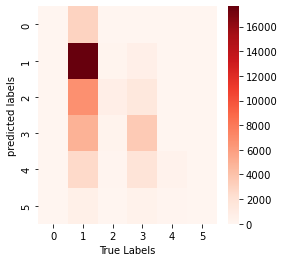

In [646]:
sns.heatmap(word_price_cm, fmt='', cmap= 'Reds')
plt.xlabel('True Labels')
plt.ylabel('predicted labels')

In [647]:
##Model 5: Use adjectives to predict price using naive bayes: 
classifydf5 = classifydf.loc[:, ["adjectives", "Price_val"]]
classifydf5.head()

,adjectives,Price_val
0,"['ripe', 'oaky', 'full', 'intense', 'rich', 'b...",Above 100
1,"['delicious', 'balanced', 'complex', 'white', ...",50-100
2,"['new', 'french', 'aromatic', 'dense', 'toasty...",50-100
3,"['top', 'la', 'highest', 'considerable', 'extr...",50-100
4,"['dark', 'ripe', 'black', 'cool', 'feels', 'to...",50-100


In [648]:
x5 = classifydf5.adjectives
y5 = classifydf5.Price_val
x_train5, x_test5, y_train5, y_test5 = tts(x5, y5, test_size=0.30, random_state=1, stratify=y5)

In [649]:
training5 = model2.fit(x_train5, y_train5)
predicted5 = model2.predict(x_test5)
scores_price5 = 100 * model2.score(x_test5,y_test5)

In [650]:
adjectivescores = cross_val_score(model2, x_train5, y_train5, cv = 10, scoring='accuracy')
print('Cross-validation scores for modeling price using adjective tokens with kfolds of 10:{}'.format(adjectivescores))
print('Average cross-validation score for this model with 10 kfolds is: {:.4f}'.format(adjectivescores.mean()))

Cross-validation scores for modeling price using adjective tokens with kfolds of 10:[0.46238812 0.46657779 0.45972196 0.45876976 0.46124548 0.46353076
 0.45686536 0.45810322 0.46338444 0.46147986]
Average cross-validation score for this model with 10 kfolds is: 0.4612


In [651]:
adjectivescores2 = cross_val_score(model2, x_train5, y_train5, cv = 5, scoring='accuracy')
print('Cross-validation scores for modeling price using adjective tokens with kfolds of 5:{}'.format(adjectivescores2))
print('Average cross-validation score for this model with 5 kfolds is: {:.4f}'.format(adjectivescores2.mean()))

Cross-validation scores for modeling price using adjective tokens with kfolds of 5:[0.4632451  0.45872215 0.46029328 0.45774413 0.46102938]
Average cross-validation score for this model with 5 kfolds is: 0.4602


In [652]:
print("The score of Mulitnomial Naive Bayes for predicting the price of wine with adjective tokens only is {} %".format(scores_price5))
print('Model accuracy score for this second model is: {0:0.4f}'. format(accuracy_score(y_test5, predicted5)))
print(classification_report(y_test5, predicted5))

The score of Mulitnomial Naive Bayes for predicting the price of wine with adjective tokens only is 46.42507998578031 %
Model accuracy score for this second model is: 0.4643
              precision    recall  f1-score   support

        0-10       0.64      0.01      0.02      3050
       10-20       0.47      0.95      0.63     18496
       20-30       0.46      0.07      0.12      8883
       30-50       0.42      0.28      0.33      8758
      50-100       0.49      0.06      0.10      4782
   Above 100       0.75      0.00      0.01      1039

    accuracy                           0.46     45008
   macro avg       0.54      0.23      0.20     45008
weighted avg       0.48      0.46      0.36     45008



In [653]:
#Print out the confusion matrix for modeling price with adjs
adj_price_cm = confusion_matrix (y_test5, predicted5)
adj_price_cm

array([[   30,  2919,    37,    60,     4,     0],
       [   11, 17512,   231,   689,    53,     0],
       [    2,  7170,   641,  1034,    35,     1],
       [    1,  5938,   289,  2431,    99,     0],
       [    3,  3010,   160,  1331,   278,     0],
       [    0,   613,    25,   295,   103,     3]])

In [654]:
##Model 6: Use nouns to predict the price_val:
classifydf6 = classifydf.loc[:, ["nouns", "Price_val"]]
classifydf6.head()

,nouns,Price_val
0,"['aromas', 'fig', 'blackberry', 'cassis', 'sla...",Above 100
1,"['mac', 'watson', 'memory', 'wine', 'mother', ...",50-100
2,"['months', '%', 'oak', 'fruit', 'ponzi', 'auro...",50-100
3,"['wine', 'bégude', 'point', 'vineyard', 'feet'...",50-100
4,"['dense', 'pure', 'opening', 'bell', 'toro', '...",50-100


In [655]:
x6 = classifydf6.nouns
y6 = classifydf6.Price_val
x_train6, x_test6, y_train6, y_test6 = tts(x6, y6, test_size=0.30, random_state=1, stratify=y6)

In [656]:
training6 = model2.fit(x_train6, y_train6)
predicted6 = model2.predict(x_test6)
scores_price6 = 100 * model2.score(x_test6,y_test6)

In [657]:
nounpricescores = cross_val_score(model2, x_train6, y_train6, cv = 10, scoring='accuracy')
print('Cross-validation scores for modeling price using noun tokens to predict price with kfolds of 10:{}'.format(nounpricescores))
print('Average cross-validation score for modeling using noun tokens to predict price with 10 kfolds is: {:.4f}'.format(nounpricescores.mean()))

Cross-validation scores for modeling price using noun tokens to predict price with kfolds of 10:[0.47724243 0.48438393 0.48514569 0.48324129 0.48381261 0.48362217
 0.48352695 0.48266997 0.48166841 0.48147795]
Average cross-validation score for modeling using noun tokens to predict price with 10 kfolds is: 0.4827


In [658]:
nounpricescores2 = cross_val_score(model2, x_train6, y_train6, cv = 5, scoring='accuracy')
print('Cross-validation scores for modeling price using noun tokens to predict price with kfolds of 5:{}'.format(nounpricescores2))
print('Average cross-validation score for modeling using noun tokens to predict price with 5 kfolds is: {:.4f}'.format(nounpricescores2.mean()))

Cross-validation scores for modeling price using noun tokens to predict price with kfolds of 5:[0.47886117 0.48105123 0.47895639 0.48145503 0.48059801]
Average cross-validation score for modeling using noun tokens to predict price with 5 kfolds is: 0.4802


In [659]:
print("The score of Mulitnomial Naive Bayes for predicting the price of wine with noun tokens only is {} %".format(scores_price6))
print('Model accuracy score for this second model is: {0:0.4f}'. format(accuracy_score(y_test6, predicted6)))
print(classification_report(y_test6, predicted6))

The score of Mulitnomial Naive Bayes for predicting the price of wine with noun tokens only is 48.68245645218628 %
Model accuracy score for this second model is: 0.4868


/Users/meichanhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        0-10       0.87      0.01      0.02      3050
       10-20       0.49      0.94      0.65     18496
       20-30       0.49      0.08      0.14      8883
       30-50       0.45      0.38      0.41      8758
      50-100       0.64      0.08      0.14      4782
   Above 100       0.00      0.00      0.00      1039

    accuracy                           0.49     45008
   macro avg       0.49      0.25      0.23     45008
weighted avg       0.51      0.49      0.39     45008



/Users/meichanhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/meichanhuang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [660]:
#Print out the confusion matrix for modeling price with nouns
noun_price_cm = confusion_matrix (y_test6, predicted6)
noun_price_cm

array([[   27,  2916,    33,    74,     0,     0],
       [    3, 17448,   266,   743,    36,     0],
       [    1,  6726,   716,  1418,    22,     0],
       [    0,  5057,   290,  3348,    63,     0],
       [    0,  2679,   127,  1604,   372,     0],
       [    0,   620,    33,   300,    86,     0]])

Finding 2: In these three models, the best performed was with the tokenized words to predict the price of wines with 49% accuracy.
The worst was with adjectives (46.4 % accuracy).   

In [661]:
'''Meichan: Last model using review to predict wine varieties, again I used tokenized words, adjectives, and nouns to predict the top four varieties of wine'''
#Investigate the classification accuracy for using review to predict the variety:
classifydf7 = classifydf.loc[:, ['word_token_cleaned', 'Variety']]

#Choose the top four with more than 10k reviews each and subset the data to make the task easier
wines = ['Chardonnay', 'Pinot Noir', 'Cabernet Sauvignon', 'Red Blend']
classifydf7 = classifydf7[classifydf7.Variety.isin(wines)]

In [662]:
classifydf7.describe()

,word_token_cleaned,Variety
count,51360,51360
unique,33031,4
top,"['yellow', 'color', 'waxy', 'nose', 'baked', '...",Chardonnay
freq,4,14412


In [663]:
#Model 7: Tokenized words to predict wine variety (Best performance)
x7 = classifydf7.word_token_cleaned
y7 = classifydf7.Variety
x_train7, x_test7, y_train7, y_test7 = tts(x7, y7, test_size=0.30, random_state=1, stratify=y7)

In [664]:
training7 = model2.fit(x_train7, y_train7)
predicted7 = model2.predict(x_test7)
scores_var7 = 100 * model2.score(x_test7,y_test7)

In [665]:
var_scores = cross_val_score(model2, x_train7, y_train7, cv = 10, scoring='accuracy')
print('Cross-validation scores for the model with tokenized words to predict wine varieties with kfolds of 10 is:{}'.format(var_scores))
print('Average cross-validation score for this model with kfolds of 10 is: {:.4f}'.format(var_scores.mean()))

Cross-validation scores for the model with tokenized words to predict wine varieties with kfolds of 10 is:[0.8907119  0.88709677 0.88261474 0.88289291 0.88428373 0.88845619
 0.89235049 0.88539638 0.8837274  0.89095967]
Average cross-validation score for this model with kfolds of 10 is: 0.8868


In [666]:
var_scores2 = cross_val_score(model2, x_train7, y_train7, cv = 5, scoring='accuracy')
print('Cross-validation scores for the model with tokenized words to predict wine varieties with kfolds of 5 is:{}'.format(var_scores2))
print('Average cross-validation score for this model with kfolds of 5 is: {:.4f}'.format(var_scores2.mean()))

Cross-validation scores for the model with tokenized words to predict wine varieties with kfolds of 5 is:[0.88749826 0.87887637 0.88386648 0.88817803 0.8867872 ]
Average cross-validation score for this model with kfolds of 5 is: 0.8850


In [667]:
print("The score of Mulitnomial Naive Bayes for predicting the variety of wine with tokenized words only is {} %".format(scores_var7))
print('Model accuracy score for this second model is: {0:0.4f}'. format(accuracy_score(y_test7, predicted7)))
print(classification_report(y_test7, predicted7))

The score of Mulitnomial Naive Bayes for predicting the variety of wine with tokenized words only is 88.74610591900311 %
Model accuracy score for this second model is: 0.8875
                    precision    recall  f1-score   support

Cabernet Sauvignon       0.81      0.86      0.83      3813
        Chardonnay       0.98      0.98      0.98      4323
        Pinot Noir       0.87      0.93      0.90      4276
         Red Blend       0.88      0.73      0.80      2996

          accuracy                           0.89     15408
         macro avg       0.89      0.87      0.88     15408
      weighted avg       0.89      0.89      0.89     15408



In [668]:
#Print out the confusion matrix for modeling varieties with tokenized words 
word_var_cm = confusion_matrix (y_test7, predicted7)
word_var_cm

array([[3261,   17,  271,  264],
       [  22, 4235,   61,    5],
       [ 199,   58, 3981,   38],
       [ 537,   22,  240, 2197]])

Text(15.0, 0.5, 'predicted labels')

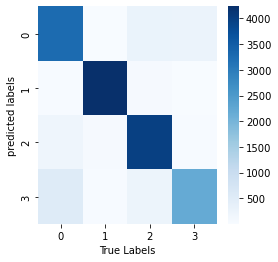

In [670]:
sns.heatmap(word_var_cm, fmt='', cmap= 'Blues')
plt.xlabel('True Labels')
plt.ylabel('predicted labels')

In [671]:
##Model 8: Use adjectives to predict wine varieties:
classifydf8 = classifydf.loc[:, ['adjectives', 'Variety']]

#Choose the top four with more than 10k reviews each and subset the data
wines = ['Chardonnay', 'Pinot Noir', 'Cabernet Sauvignon', 'Red Blend']
classifydf8 = classifydf8[classifydf8.Variety.isin(wines)]

In [672]:
x8 = classifydf8.adjectives
y8 = classifydf8.Variety
x_train8, x_test8, y_train8, y_test8 = tts(x8, y8, test_size=0.30, random_state=1, stratify=y8)

In [673]:
training8 = model2.fit(x_train8, y_train8)
predicted8 = model2.predict(x_test8)
scores_var8 = 100 * model2.score(x_test8,y_test8)

In [674]:
var_adjscores = cross_val_score(model2, x_train8, y_train8, cv = 10, scoring='accuracy')
print('Cross-validation scores for the model with adjectives to predict wine varieties with kfolds of 10 is:{}'.format(var_adjscores))
print('Average cross-validation score for this model with kfolds of 10 is: {:.4f}'.format(var_adjscores.mean()))

Cross-validation scores for the model with adjectives to predict wine varieties with kfolds of 10 is:[0.69354839 0.68715239 0.70431154 0.69151599 0.69179416 0.68873435
 0.7015299  0.68929068 0.69151599 0.6759388 ]
Average cross-validation score for this model with kfolds of 10 is: 0.6915


In [675]:
var_adjscores2 = cross_val_score(model2, x_train8, y_train8, cv = 5, scoring='accuracy')
print('Cross-validation scores for the model with adjectives to predict wine varieties with kfolds of 5 is:{}'.format(var_adjscores2))
print('Average cross-validation score for this model with kfolds of 5 is: {:.4f}'.format(var_adjscores2.mean()))

Cross-validation scores for the model with adjectives to predict wine varieties with kfolds of 5 is:[0.68752607 0.69475734 0.6867872  0.69374131 0.68191933]
Average cross-validation score for this model with kfolds of 5 is: 0.6889


In [676]:
print("The score of Mulitnomial Naive Bayes for predicting the variety of wine with adjectives only is {} %".format(scores_var8))
print('Model accuracy score for this second model is: {0:0.4f}'. format(accuracy_score(y_test8, predicted8)))
print(classification_report(y_test8, predicted8))

The score of Mulitnomial Naive Bayes for predicting the variety of wine with adjectives only is 70.18431983385256 %
Model accuracy score for this second model is: 0.7018
                    precision    recall  f1-score   support

Cabernet Sauvignon       0.61      0.64      0.62      3813
        Chardonnay       0.81      0.86      0.83      4323
        Pinot Noir       0.64      0.72      0.68      4276
         Red Blend       0.79      0.53      0.64      2996

          accuracy                           0.70     15408
         macro avg       0.71      0.69      0.69     15408
      weighted avg       0.71      0.70      0.70     15408



In [677]:
#Print out the confusion matrix for modeling varieties with adjectives
adj_var_cm = confusion_matrix (y_test8, predicted8)
adj_var_cm

array([[2442,  298,  848,  225],
       [ 217, 3702,  341,   63],
       [ 670,  398, 3079,  129],
       [ 706,  190,  509, 1591]])

In [678]:
##Model 9: Use nouns to predict wine varieties:
classifydf9 = classifydf.loc[:, ['nouns', 'Variety']]

#Choose the top four with more than 10k reviews each and subset the data
wines = ['Chardonnay', 'Pinot Noir', 'Cabernet Sauvignon', 'Red Blend']
classifydf9 = classifydf9[classifydf9.Variety.isin(wines)]

In [679]:
x9 = classifydf9.nouns
y9 = classifydf9.Variety
x_train9, x_test9, y_train9, y_test9 = tts(x9, y9, test_size=0.30, random_state=1, stratify=y9)

In [544]:
training9 = model2.fit(x_train9, y_train9)
predicted9 = model2.predict(x_test9)
scores_var9 = 100 * model2.score(x_test9,y_test9)

In [680]:
var_nounscores = cross_val_score(model2, x_train9, y_train9, cv = 10, scoring='accuracy')
print('Cross-validation scores for the model with nouns to predict wine varieties with kfolds of 10 is:{}'.format(var_nounscores))
print('Average cross-validation score for this model with kfolds of 10 is: {:.4f}'.format(var_nounscores.mean()))

Cross-validation scores for the model with nouns to predict wine varieties with kfolds of 10 is:[0.87235818 0.87291435 0.87788595 0.87009736 0.88038943 0.88233658
 0.88400556 0.87371349 0.8759388  0.88066759]
Average cross-validation score for this model with kfolds of 10 is: 0.8770


In [681]:
var_nounscores2 = cross_val_score(model2, x_train9, y_train9, cv = 5, scoring='accuracy')
print('Cross-validation scores for the model with adjectives to predict wine varieties with kfolds of 5 is:{}'.format(var_nounscores2))
print('Average cross-validation score for this model with kfolds of 5 is: {:.4f}'.format(var_nounscores2.mean()))

Cross-validation scores for the model with adjectives to predict wine varieties with kfolds of 5 is:[0.86928105 0.87164511 0.87788595 0.87885953 0.87802503]
Average cross-validation score for this model with kfolds of 5 is: 0.8751


In [683]:
print("The score of Mulitnomial Naive Bayes for predicting the variety of wine with nouns only is {} %".format(scores_var9))
print('Model accuracy score for this second model is: {0:0.4f}'. format(accuracy_score(y_test9, predicted9)))
print(classification_report(y_test9, predicted9))

The score of Mulitnomial Naive Bayes for predicting the variety of wine with nouns only is 87.54543094496366 %
Model accuracy score for this second model is: 0.8755
                    precision    recall  f1-score   support

Cabernet Sauvignon       0.81      0.83      0.82      3813
        Chardonnay       0.96      0.97      0.96      4323
        Pinot Noir       0.86      0.92      0.89      4276
         Red Blend       0.86      0.73      0.79      2996

          accuracy                           0.88     15408
         macro avg       0.87      0.86      0.87     15408
      weighted avg       0.88      0.88      0.87     15408



In [684]:
#Print out the confusion matrix for modeling varieties with nouns
noun_var_cm = confusion_matrix (y_test9, predicted9)
noun_var_cm

array([[3173,   41,  298,  301],
       [  18, 4189,  111,    5],
       [ 200,   93, 3937,   46],
       [ 533,   38,  235, 2190]])

Finding 3: In these three models, the best performed was with the tokenized words to predict the top 4 varieties of wines, and the worst was with adjectives (69.15% accuracy). 

Main findings for this project: The best model we ran with wine reviews was to predict the wine varieties with an accuracy rate of approximately 89%.
The implication is that there are certain descriptors that are used to describe certain types of wines. 